# Optical Satellite Imagery Introduction

## Introduction to images

So first of all, what is an image? There's nothing special about an image array: when we have at least 2 spatial dimensions to work with (i.e. $x$ and $y$), we call these datasets 'images'. An image may be monochrome (no spectral information, only spatial) or colour (spectral and spatial information).

Images are made up of pixels. In a monochrome image, every pixel is represented by a single value: the brightness. If we are looking at an image of a real object, the pixel value is proportional to the amount of light reflected by the object and absorbed by the camera sensor.

Computers represent colours in terms of their red, green and blue brightnesses. These brightness different mixtures or ratios give different colours. We sometimes refer to these kind of colour images as RGB images. Every pixel in a colour image is described by 3 values: one for each of the red, green and blue channels.

More info can be found here https://en.wikipedia.org/wiki/RGB_color_model

#### Question: write a quick definition for each of the following: pixel, RGB, colour channel

## Sentinel-2 

Artificial satellites have many functions in communications, telemetry (e.g. GPS), scientific research (e.g. astronomy) and earth observation.

Today, we're going to look at the European Space Agency Sentinel-2 mission (read more about it here http://www.esa.int/Our_Activities/Observing_the_Earth/Copernicus/Sentinel-2).

This satellite gathers a special kind of colour image data called 'multi-spectral imagery'. In addition to Red, Green and Blue, this satellite also captures bands in the infrared.

## The task today...

You will use the Sentinel data to estimate the percentage of 'green space' in a region of central London.

In [1]:
1+2

3

In [2]:
import matplotlib.pyplot as plt
import numpy as np
# read in the dataset
im1 = np.load('data/S2_London.npy')

## The dataset
The data are provided as atmospherically-corrected values. The dataset is a 3D array of size 1000 x 1000 x 4, providing you with 4 bands: Blue, Green, Red, Infrared. Each pixel is exactly 10m x 10m

In [3]:
print('Array dimensions: {}'.format(im1.shape))

Array dimensions: (1000, 1000, 4)


In [4]:
pixel_size = 10

## RGB images

#### Question: Find the approximate location of the image and annotate some of the key regions

Clue: the image is located somewhere in this area: https://tinyurl.com/yb43aerz

### A note about generating nice looking RGB images

Sentinel 2 data are surface level reflectance values. These are integer values in range 0-10000 (actually, sometimes these values can be larger than 10000, but we will ignore that for now) where 10,000 represents 100% reflectance.

So it might make sense to divide all values by 10,000 to put them in the range 0-1 and make them interpretable by matplotlib as RGB coordinates

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


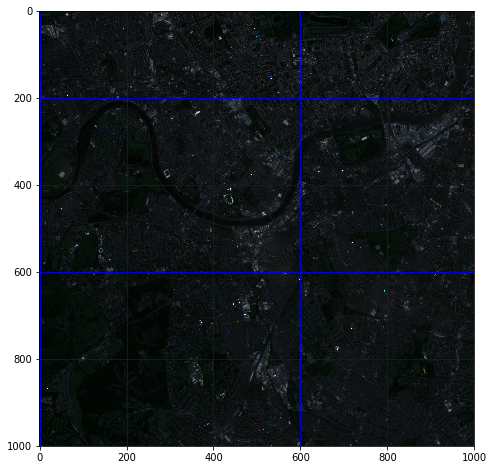

In [5]:
plt.figure(figsize=(8,8))
plt.imshow(im1[:,:,:3]/10000)

# gridlines
plt.grid(color='blue')
plt.show()

however, this doesn't make an image we can interpret. In order to make something resembling what we would actually see, we can normalize the colour channels using a quick and dirty method: [histogram equalisation](https://en.wikipedia.org/wiki/Histogram_equalization)

In [6]:
def image_histogram_equalization(image):
    """ Image histogram equlisation"""
    # from http://www.janeriksolem.net/2009/06/histogram-equalization-with-python-and.html

    # get image histogram
    image_histogram, bins = np.histogram(image.flatten(), 256, normed=True)
    cdf = image_histogram.cumsum() # cumulative distribution function
    cdf = (255-1) * cdf / cdf[-1] # normalize

    # use linear interpolation of cdf to find new pixel values
    image_equalized = np.interp(image.flatten(), bins[:-1], cdf)
    
    if len(image.shape) == 3:
        return image_equalized.reshape(image.shape).astype('uint8')[:,:,::-1]
    else:
        return image_equalized.reshape(image.shape).astype('uint8')

/anaconda3/envs/medellin/lib/python3.6/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  


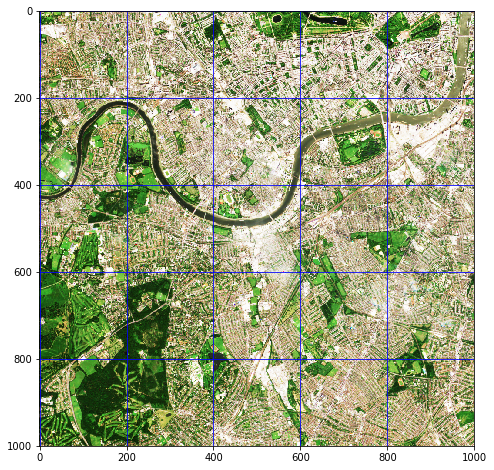

In [7]:
plt.figure(figsize=(8,8))
plt.imshow(image_histogram_equalization(im1[:,:,:3]))

# gridlines
plt.grid(color='blue')
plt.show()

#### Question: Can we work out how much green space there is from the RGB information?

# Individual colour channels

/anaconda3/envs/medellin/lib/python3.6/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  


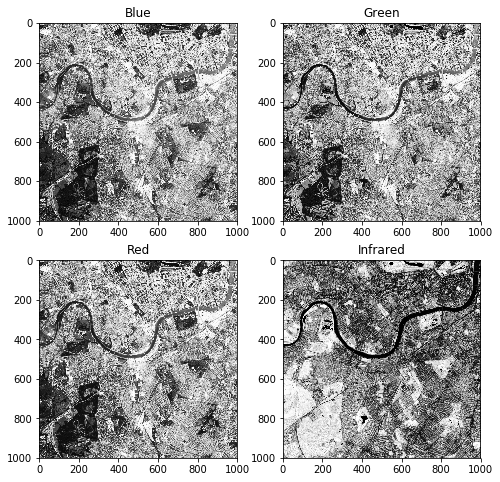

In [8]:
f = plt.figure(figsize=(8,8))

f.add_subplot(221)
plt.imshow(image_histogram_equalization(im1[:,:,0]),'binary_r')
plt.title('Blue')

f.add_subplot(222)
plt.imshow(image_histogram_equalization(im1[:,:,1]),'binary_r')
plt.title('Green')

f.add_subplot(223)
plt.imshow(image_histogram_equalization(im1[:,:,2]),'binary_r')
plt.title('Red')

f.add_subplot(224)
plt.imshow(image_histogram_equalization(im1[:,:,3]),'binary_r')
plt.title('Infrared')
plt.show()

## Using band ratio
Each pixel in our dataset is made up of 4 values. These values represent how bright the surface was in each of the four colour bands (blue, green, red, infrared). Band 1 is the blue band. A high value in the blue band means that the surface reflected lots of blue light back to the sensor onboard the satellite. Conversely, if we had a low value, we would know that the surface would be less reflective in the blue.

Usually, we aren't interested in the absolute brightness and so we prefer to use the ratios of brightness between bands.

For example, we can calculate a reflectance (R) ratio called the 'Normalised Differential Vegetation Index':

$R_{NDVI}=(R_{IR}-R_{Red})/(R_{IR}+R_{Red})$

This ignores the overall brightness and just indicates the relative difference in reflectance between the 2 wavebands.

Lets see what happens if we calculate this for the image:

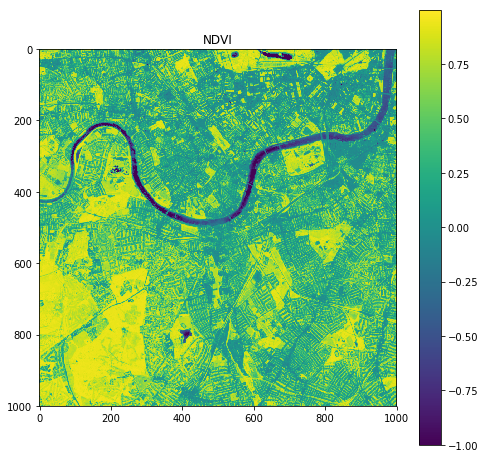

In [9]:
# function for doing the calculation
def calculate_NDVI(image):
    """ This function calculates the Normalised Differential Vegetation Index for
    the 4-band data provided in this exercise. A 2D array is returned"""
    r = image[:,:,2]
    ir = image[:,:,3]
    return (ir-r)/(ir+r)
# calculate NDVI
ndvi = calculate_NDVI(im1)

# plot
plt.figure(figsize=(8,8))
plt.imshow(ndvi,'viridis')
plt.title('NDVI')
plt.colorbar()
plt.show()

#### Question: Why is the water so easy to identify using NDVI?
clue: https://en.wikipedia.org/wiki/Water#Color_and_appearance


#### Question: Does vegetation have high or low values of NDVI? Why
clue: https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index

## Thresholding

We can do a kind of filtering on the arrays so that we're only left with pixels which satisfy certain conditions.

In [10]:
water_threshold = -.25
vegetation_threshold = .5

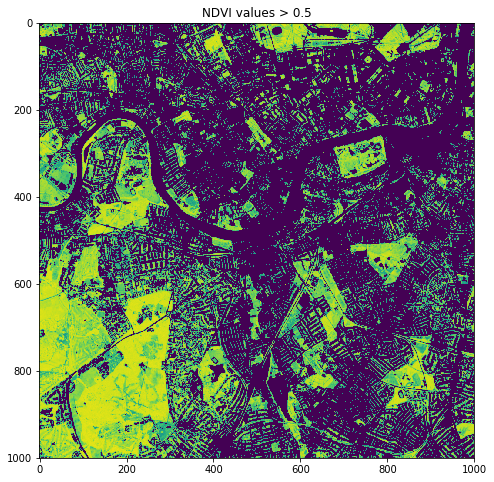

In [11]:
# keep all values bigger than the vegetation_threshold
mask = ndvi > vegetation_threshold

# calculate the area above threshold in km2
area = (mask.sum()*10)/1e6

# plot
plt.figure(figsize=(8,8))
plt.imshow(mask*ndvi,'viridis')
plt.title('NDVI values > {}'.format(vegetation_threshold))
plt.show()

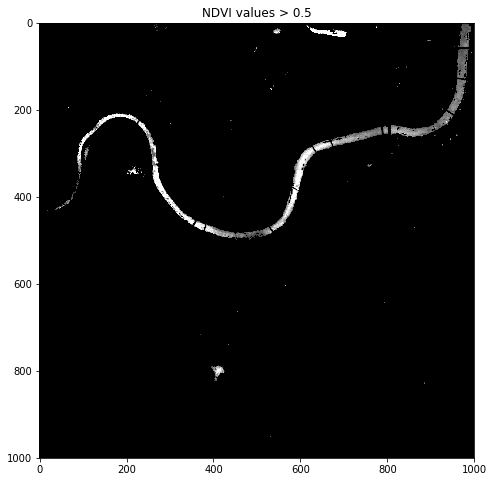

In [12]:
# keep all values below the water_threshold
mask1 = ndvi < water_threshold

# calculate the area above threshold in km2
area = (mask1.sum()*10)/1e6

# plot
plt.figure(figsize=(8,8))
plt.imshow(mask1*ndvi,'binary')
plt.title('NDVI values > {}'.format(vegetation_threshold))
plt.show()

#### Question: What are the optimum values to filter water and vegetation? 

## Small scale investigations
Using the square brackets - [] we can define a small region of the image to look at.

### Exercise 1
Select a small area of the image by changing the numbers in the square brackets. Use google maps/ google street view to investigate the area in your image. In your presentation, you should include annotations on your image to identify different types of green space (e.g. garden, park, etc.). Do different types of vegetation have different NDVI values (e.g. trees v. grass?) Can you use this to identify forest? Why might it be useful to know how much green space is in a city?

### Example:

I choose an area between y=700 and y=900, and x=300 and x=500. I set the NDVI to .5 and plotted this out. I can see different types of green space in the image, so I used google maps to investigate further. I counted the number of pixels where the NDVI was greater than .5 and divided this by the total number of pixels in the small area. This gave me the proportion of the area covered with vegetations in my small area. I would now go and have a look google maps/ streetview https://tinyurl.com/y75kh2lf and begin investigating what the different areas are. Are they gardens? Can I see forested areas? I might be interested in comparing this to another area of this image - do different areas have different percentage vegetation?

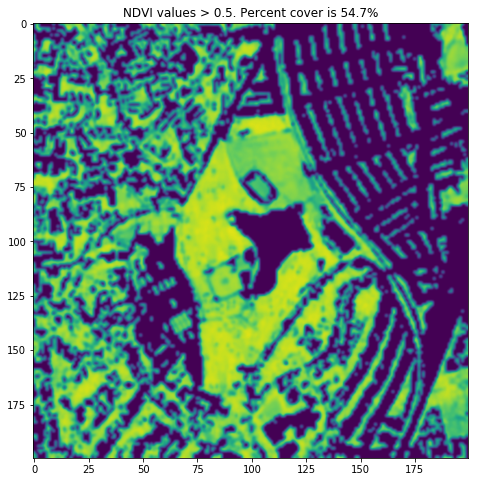

In [13]:
# define our small area
park = im1[700:900,300:500]

# make an ndvi image for that area
park_ndvi = calculate_NDVI(park)

# decide what our threshold is
threshold = .5

# threshold the ndvi image array
mask = park_ndvi > threshold

# calculate the area above threshold in km2
area = (mask.sum()/(park.shape[0]*park.shape[1]))*100

# plot
f = plt.figure(figsize=(8,8))
plt.imshow(mask*park_ndvi,'viridis',interpolation='bicubic')
plt.title('NDVI values > {}. Percent cover is {:.1f}%'.format(threshold,area))
plt.show()